## Introducere

Imaginile hiperspectrale sunt imagini care captureaza informatii pe mai multe benzi ale spectrului electromagnetic, fiecare banda avand o latime de banda foarte ingusta. Aceste imagini sunt utilizate in domenii precum:

- **Agricultura** (monitorizarea culturilor)
- **Geologie** (identificarea mineralelor)
- **Monitorizarea mediului** (analiza poluarii)
- **Analiza urbana** (detectarea schimbarilor de peisaj)

Metodele de clasificare supervizata sunt utilizate pentru a eticheta datele intr-o maniera automata pe baza unui set de date etichetat. Doua metode cunoscute sunt:

1. **Support Vector Machines (SVM)**: SVM este un algoritm de invatare supervizata folosit pentru clasificarea datelor prin gasirea unui hiperplan care separa datele in clase.
   - **Avantaje**: Eficient in seturi de date de dimensiuni medii sau mici; functioneaza bine in spatii de dimensiuni mari.
   - **Dezavantaje**: Poate deveni ineficient pentru seturi de date foarte mari datorita cerintelor mari de calcul, mai ales cand se utilizeaza kerneluri non-liniare; depinde mult de parametrii alesi.

2. **Neural Networks (NN)**: Modelele de retele neuronale sunt inspirate din creierul uman si pot invata relatii complexe din date.
   - **Avantaje**: Pot invata reprezentari abstracte ale datelor; eficienta mare in procesarea imaginilor.
   - **Dezavantaje**: Necesita resurse mari de calcul si sunt susceptibile la overfitting.

## Importare biblioteci

Pentru inceput, am importat urmatoarele biblioteci: **pandas**, **numpy** si **matplotlib** pentru prelucrarea datelor si vizualizare, **sklearn** pentru SVM, PCA, preprocesare si evaluarea performantelor, si **tensorflow** pentru implementarea retelei neuronale.

In [175]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Incarcare set de date

Am incarcat setul de date [GHISACONUS](https://lpdaac.usgs.gov/products/ghisaconusv001) din format csv, omitand primele 6 linii pentru a sari peste randurile cu metadate sau informatii suplimentare. Setul de date nu contine imagini, ci valori numerice corespunzatoare intensitatilor pentru diferite frecvente spectrale, obtinute prin masuratori ale unui senzor hiperspectral. Am selectat doar coloanele relevante pentru clasificare, unde **X** contine aceste valori spectrale pentru fiecare frecventa, iar **y** reprezinta etichetele pentru culturi.

In [176]:
df = read_csv("GHISACONUS.csv", skiprows=6)
X = df.iloc[:, 11:]
y = df['Crop']

print("Metadate:")
df.info()
print("\nInformatii feature-uri:\n", df.columns, "\n")
df.head()

Metadate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6988 entries, 0 to 6987
Columns: 209 entries, UniqueID to X2395
dtypes: float64(200), int64(5), object(4)
memory usage: 11.1+ MB

Informatii feature-uri:
 Index(['UniqueID', 'Country', 'AEZ', 'Image', 'Month', 'Year', 'jd', 'long',
       'lat', 'Crop',
       ...
       'X2305', 'X2315', 'X2325', 'X2335', 'X2345', 'X2355', 'X2365', 'X2375',
       'X2385', 'X2395'],
      dtype='object', length=209) 



,UniqueID,Country,AEZ,Image,Month,Year,jd,long,lat,Crop,...,X2305,X2315,X2325,X2335,X2345,X2355,X2365,X2375,X2385,X2395
0,1466,USA,7,EO1H0440332012234110KD_SGS_01,8,2012,234,-121.663419,38.534516,corn,...,7.380592,7.327904,6.881876,6.616288,6.346634,NaN,NaN,NaN,NaN,NaN
1,1467,USA,7,EO1H0440332012234110KD_SGS_01,8,2012,234,-121.671589,38.504744,corn,...,8.090403,7.894839,7.263033,6.536649,5.663291,NaN,NaN,NaN,NaN,NaN
2,1469,USA,7,EO1H0440332012234110KD_SGS_01,8,2012,234,-121.597588,38.614056,corn,...,5.116303,4.833205,4.817732,4.652525,3.790456,NaN,NaN,NaN,NaN,NaN
3,1470,USA,7,EO1H0440332012234110KD_SGS_01,8,2012,234,-121.687293,38.571702,corn,...,6.291307,6.922908,6.943876,6.461839,5.696439,NaN,NaN,NaN,NaN,NaN
4,1476,USA,7,EO1H0440332012234110KD_SGS_01,8,2012,234,-121.625189,38.572225,rice,...,6.007986,4.820400,3.084297,1.322807,1.087548,NaN,NaN,NaN,NaN,NaN


## Explorare date

Am calculat spectrul mediu pentru fiecare tip de cultura, folosind datele spectrale disponibile, unele benzi de frecventa avand goluri cauzate de lipsa datelor.

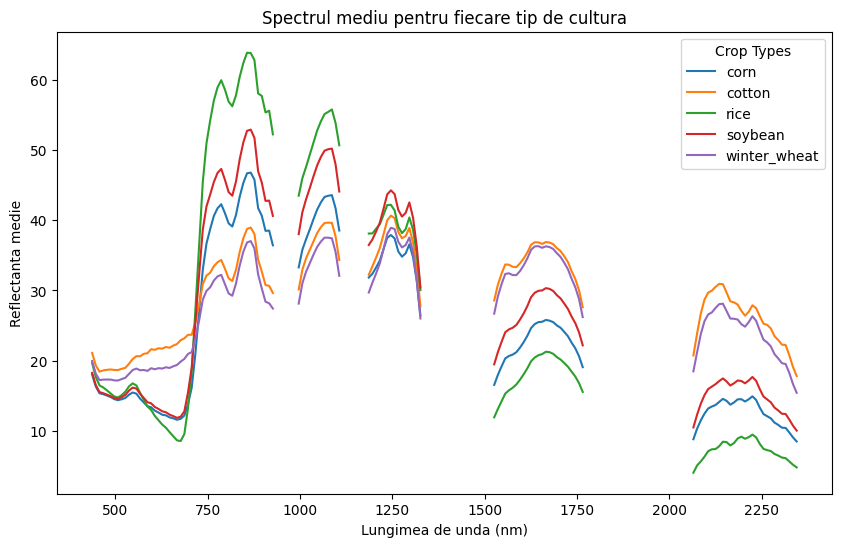

In [177]:
mean_spectrum = X.groupby(y).mean()
w = np.linspace(427, 2395, mean_spectrum.shape[1])

plt.figure(figsize=(10, 6))
for crop in mean_spectrum.index:
    plt.plot(w, mean_spectrum.loc[crop], label=crop)

plt.xlabel('Lungimea de unda (nm)')
plt.ylabel('Reflectanta medie')
plt.title('Spectrul mediu pentru fiecare tip de cultura')
plt.legend(title='Crop Types')
plt.show()

## Preprocesare date

Am eliminat coloanele care contineau doar valori lipsa, am inlocuit valorile lipsa din restul coloanelor cu medianele acestora, si am convertit etichetele in coduri numerice pentru a putea fi utilizate in modele de clasificare. Apoi, am normalizat datele folosind **StandardScaler** si am aplicat **PCA** pentru a reduce dimensiunea datelor la 2 componente, cu scopul de a facilita vizualizarea (dar in antrenare si testare am folosit datele care nu au fost reduse). Datele au fost impartite in seturi de antrenare si testare utilizand **train_test_split**, iar in final, am afisat dimensiunile seturilor de date pentru a verifica corectitudinea prelucrarii.

In [178]:
X = X.dropna(axis=1, how='all')
X = X.fillna(X.median())
y = y.astype('category').cat.codes

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_scaled_2d = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
print("Forma set de antrenare:",X_train.shape)
print("Forma set de test:",X_test.shape)

Forma set de antrenare: (5590, 131)
Forma set de test: (1398, 131)


## Vizualizare date preprocesate

Setul de date este vizualizat in **2D** dupa aplicarea **PCA**, folosind cele doua componente principale. Punctele sunt colorate in functie de etichetele **y**, unde fiecare culoare reprezinta un tip diferit de cultura.

<ipython-input-179-76bc69528d9b>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_scaled_2d[:, 0], X_scaled_2d[:, 1], c=y, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))), alpha=0.6)


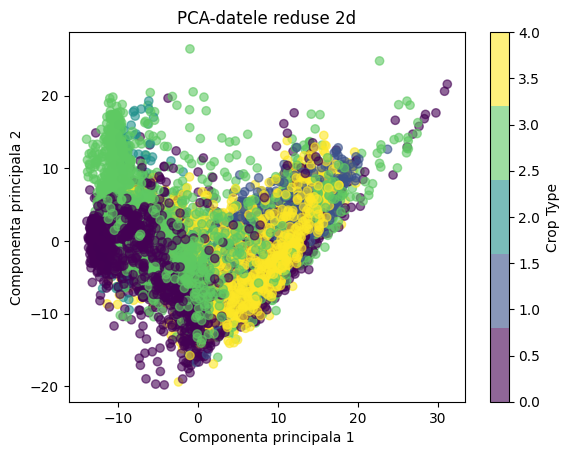

In [179]:
plt.scatter(X_scaled_2d[:, 0], X_scaled_2d[:, 1], c=y, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))), alpha=0.6)
plt.colorbar(label='Crop Type')
plt.xlabel('Componenta principala 1')
plt.ylabel('Componenta principala 2')
plt.title('PCA-datele reduse 2d')
plt.show()

## Implementare metode supervizate

### SVM

Am implementat metoda **SVM** cu kernel liniar pentru clasificare. Modelul a fost antrenat pe setul de date de antrenament, iar apoi am facut predictii pe ambele seturi, de antrenament si de test.

In [180]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm = svm.predict(X_test)

### NN

Am creat un **NN** cu 4 straturi dense, folosind activari **ReLU** pentru straturile ascunse si **Softmax** pentru iesire. Modelul a fost antrenat cu optimizatorul **Adam** si functia de pierdere **sparse categorical crossentropy** pe setul de antrenament pentru 15 de epoci, iar apoi am facut predictii pe seturile de antrenament si test.


In [181]:
nn = Sequential()
nn.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(len(np.unique(y)), activation='softmax'))

nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

y_train_pred_nn = np.argmax(nn.predict(X_train), axis=1)
y_test_pred_nn = np.argmax(nn.predict(X_test), axis=1)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5855 - loss: 1.0292 - val_accuracy: 0.7096 - val_loss: 0.7869
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7241 - loss: 0.7245 - val_accuracy: 0.7403 - val_loss: 0.6681
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7589 - loss: 0.6201 - val_accuracy: 0.7504 - val_loss: 0.6300
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7854 - loss: 0.5546 - val_accuracy: 0.8019 - val_loss: 0.5023
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8043 - loss: 0.5073 - val_accuracy: 0.7904 - val_loss: 0.5010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8134 - loss: 0.4716 - val_accuracy: 0.8276 - val_loss: 0.4462
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8254 - loss: 0.4362 - val_accuracy: 0.8433 - val_loss: 0.4142
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8442 - loss: 0.4103 - val_accuracy: 0.8312 - val_

## Evaluare si vizualizare rezultate

### SVM

Evaluarea **SVM** arata o acuratete de **83%** pe **train** si **80%** pe **test**. Performantele sunt bune pentru clasele majore, dar modelul intampina dificultati in clasificarea claselor mai mici, iar matricea de confuzie arata zonele unde modelul greseste mai frecvent.

Evaluare SVM:
Train:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      2091
           1       0.84      0.82      0.83       666
           2       0.99      0.92      0.95        89
           3       0.83      0.81      0.82      1667
           4       0.79      0.74      0.76      1077

    accuracy                           0.83      5590
   macro avg       0.86      0.83      0.84      5590
weighted avg       0.83      0.83      0.83      5590

Test:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       531
           1       0.79      0.79      0.79       157
           2       0.88      0.81      0.85        27
           3       0.83      0.76      0.80       419
           4       0.76      0.70      0.73       264

    accuracy                           0.80      1398
   macro avg       0.81      0.79      0.80      1398
weighted avg       0.80      0.80      0.80     

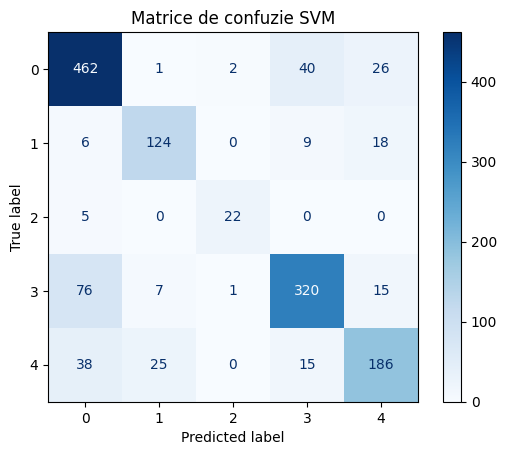

In [182]:
print("Evaluare SVM:")
print("Train:\n", classification_report(y_train, y_train_pred_svm))
print("Test:\n", classification_report(y_test, y_test_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_svm, cmap='Blues')
plt.title('Matrice de confuzie SVM')
plt.show()

### NN

Evaluarea modelului **NN** arata o acuratete de **90%** pe **train** si **88%** pe **test**. Performantele sunt bune in general, cu precizie mai mare pentru clasele mari, insa modelul inregistreaza o scadere a performantelor pentru clasele mai mici, dar nu atat de semnificativa ca in cazul SVM, iar matricea de confuzie evidentiaza greselile facute de retea.

Evaluare NN:
Train:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      2091
           1       0.88      0.86      0.87       666
           2       0.97      0.84      0.90        89
           3       0.92      0.87      0.90      1667
           4       0.88      0.88      0.88      1077

    accuracy                           0.90      5590
   macro avg       0.91      0.88      0.90      5590
weighted avg       0.90      0.90      0.90      5590

Test:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       531
           1       0.85      0.84      0.85       157
           2       0.95      0.78      0.86        27
           3       0.90      0.85      0.87       419
           4       0.86      0.84      0.85       264

    accuracy                           0.88      1398
   macro avg       0.89      0.85      0.87      1398
weighted avg       0.88      0.88      0.88      

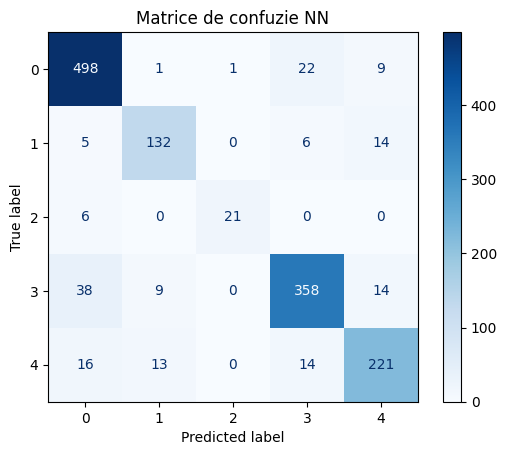

In [183]:
print("Evaluare NN:")
print("Train:\n", classification_report(y_train, y_train_pred_nn))
print("Test:\n", classification_report(y_test, y_test_pred_nn))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_nn, cmap='Blues')
plt.title('Matrice de confuzie NN')
plt.show()

## Concluzie


In urma evaluarii performantelor, retelele neuronale (NN) au avut o performanta mai buna decat SVM, cu o acuratete mai mare atat pe setul de antrenament, cat si pe cel de test. Acest lucru se datoreaza capacitatii retelelor de a invata relatii complexe din date, fiind mai eficiente in gestionarea unui numar mare de benzi spectrale. Pe de alta parte, SVM poate fi mai sensibil la zgomot, avand performante mai scazute in fata datelor complexe sau zgomotoase, NN fiind mai robuste in fata dimensionalitatii mari a datelor.